# 一、导入工具包

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller 
from statsmodels.stats.diagnostic import acorr_ljungbox #用于白噪声检验
import scipy.stats as scs  #用于绘制ACF和PACF图
from statsmodels.graphics.api import qqplot
import matplotlib.pylab as plt
from matplotlib.pylab import style
import plotly.express as px
style.use('ggplot')
from arch.unitroot import ADF
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x) 
np.set_printoptions(precision=5, suppress=True) 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# 二、导入数据

In [2]:
number = 72

In [3]:
data = pd.read_csv(r'E:/my first paper code/03.交通拥堵指数预测/03-3 AR预测/data/road%d.csv'%number)

In [4]:
data

,date,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,EXPONENT
0,2018/7/1 0:00,0,0,0,0,0,0,1,3
1,2018/7/1 0:05,0,0,0,0,0,0,1,2
2,2018/7/1 0:10,0,0,0,0,0,0,1,2
3,2018/7/1 0:15,0,0,0,0,0,0,1,2
4,2018/7/1 0:20,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...
42043,2018/11/23 23:35,0,0,0,0,0,1,0,1
42044,2018/11/23 23:40,0,0,0,0,0,1,0,1
42045,2018/11/23 23:45,0,0,0,0,0,1,0,1
42046,2018/11/23 23:50,0,0,0,0,0,1,0,1


# 三、数据分析

- 从严格意义上说，只有数据通过平稳性检验和非白噪声检验才能用时间序列模型。

## （一）原始数据分析

### 1.分析原始数据是否平稳

- 何为平稳：
    - 均值是否恒定： 平稳时间序列的均值应该在整个时间范围内保持大致恒定。如果均值随时间变化而明显波动，则很可能不是平稳的。
    - 方差是否恒定： 平稳时间序列的方差应该在整个时间范围内基本保持恒定。如果方差出现明显变化，特别是随着时间增长而增大，那么时间序列就不太可能是平稳的。
    - 季节性和周期性： 如果时间序列展现出重复性的模式或周期性的波动，可能表明它不是平稳的。这种情况下，可能需要进行差分操作（differencing）来使其平稳。
    - 自相关性： 平稳时间序列的自相关性应该随着时滞程度的增加而迅速衰减至零。如果时间序列在较长延迟下仍然显示明显的自相关性，可能不是平稳的。

#### （1）绘制折线图直观观察 

fig = px.line(data, x=data.index, y='EXPONENT', title='Original_data Plot')
fig.show()

- 根据上面的图形的结果，可以看出数据可能存在季节性

#### （2）进行单位根检验

- 单位根检验的原假设是存在一个单位根（即时间序列数据是非平稳的）

print("单位根检验:\n")
print(ADF(data.EXPONENT.dropna()))

- 单位根检验：对原始数据进行单位根检验，得到：1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，本数据中，P-value为0.000，接近0；ADF Test result为-28.036，同时小于1%、5%、10%下的值，即说明很好地拒绝原假设，即原始数据是平稳的。

### 2.分析数据是否为非白噪声（时间t上相关）序列

#### （1）Ljung-Box Q检验

- Ljung-Box Q检验的原假设是数据值在某一滞后数（在本例中为 10）之前是随机和独立的，即为白噪声序列。

# 进行Ljung-Box Q检验
lbvalue, pvalue = acorr_ljungbox(data.EXPONENT, lags=[10], return_df=False)

# 输出检验结果
print("Ljung-Box Q检验的统计量:", lbvalue)
print("对应的P值:", pvalue)

# 可视化白噪声序列
plt.plot(data.EXPONENT)
plt.title("White Noise Sequence")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

- 对于Ljung-Box Q检验来说，当统计量的P值小于显著性水平0.05，则可以以95%的置信水平拒绝原假设，认为序列为非白噪声序列（否则，接受原假设，认为序列为纯随机序列）。
- 本例中，由于P值为0，远小于0.05，所以可以显著地拒绝原假设（即认为时间序列是非白噪声的），即是非随机产生的序列，具有时间上的相关性。

### 3.确定数据平稳且为非噪声序列以后，可以进行建模

- 自回归移动平均模型(ARMA(p，q))是时间序列中最为重要的模型之一，它主要由两部分组成： AR代表p阶自回归过程，MA代表q阶移动平均过程。

#### （1）构建ARMA(p，q)模型

- 定阶：通过ACF和PACF图确定p和q的值

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

tsplot(data['EXPONENT'], lags=20)

- 判断规则
    - 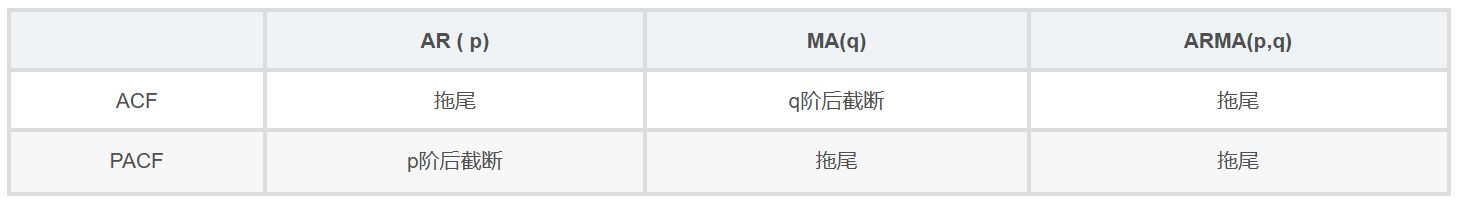

- 本例中，ACF是拖尾，PACF是4阶后截断，因此采用AR(4)模型

- 时间序列数据平稳且为非白噪声序列，PACF截尾，但ACF呈现周期性拖尾，什么原因？
    - 在时间序列分析中，如果时间序列数据是平稳的且不是白噪声序列，则它可能会展现出一些复杂的自相关和偏自相关特征。在这种情况下，PACF（Partial Autocorrelation Function）截尾而ACF（Autocorrelation Function）呈现周期性拖尾的情况可能出现。一种可能的解释是，当时间序列存在某种周期性影响时，ACF会展现出周期性的拖尾效应。这可以被用来识别序列中的季节性模式或其他周期性因素。即使数据是平稳的，其ACF仍然可能显示出周期性结构或波峰，表明序列之间存在滞后相关性。这种情况下，你可以考虑使用季节性差分（Seasonal Differencing）或者模型上引入季节性组件来处理这种周期性结构。总体而言，当PACF截尾而ACF呈现周期性拖尾时，表明序列可能有季节性变化在里面，需要进一步探索和调查。可以考虑拟合适当的季节性模型，比如季节性ARIMA（SARIMA）等，以更好地捕捉并建模这种季节性行为。

### 3.确定数据平稳且为非噪声序列以后，可以进行建模

#### （1）构建ARMA(p，q)模型

- 定阶：通过ACF和PACF图确定p和q的值

In [ ]:
import plotly.express as px
import statsmodels.api as sm

def PLOT_ACF_AND_PACF(pands_series_data,nlags):
    
    # 计算ACF和PACF
    acf_vals = sm.tsa.acf(pands_series_data, nlags)
    print(len(acf_vals))
    pacf_vals = sm.tsa.pacf(pands_series_data, nlags)
    print(len(pacf_vals))

    # 绘制ACF图
    fig_acf = px.line(x=range(0,len(acf_vals)), y=acf_vals, title='Autocorrelation Function')
    fig_acf.add_hline(y=0, line_dash="dash", line_color="gray", annotation_text="Zero Line", annotation_position="bottom right")
    fig_acf.add_hline(y=2/np.sqrt(len(pands_series_data)), line_dash="dash", line_color="blue", annotation_text="Upper SD", annotation_position="top left")
    fig_acf.add_hline(y=-2/np.sqrt(len(pands_series_data)), line_dash="dash", line_color="blue", annotation_text="Lower SD", annotation_position="bottom left")
    fig_acf.show()

    # 绘制PACF图
    fig_pacf = px.line(x=range(0,len(pacf_vals)), y=pacf_vals, title='Partial Autocorrelation Function')
    fig_pacf.add_hline(y=0, line_dash="dash", line_color="gray", annotation_text="Zero Line", annotation_position="bottom right")
    fig_pacf.add_hline(y=2/np.sqrt(len(pands_series_data)), line_dash="dash", line_color="blue", annotation_text="Upper SD", annotation_position="top left")
    fig_pacf.add_hline(y=-2/np.sqrt(len(pands_series_data)), line_dash="dash", line_color="blue", annotation_text="Lower SD", annotation_position="bottom left")
    fig_pacf.show()
    
    return

PLOT_ACF_AND_PACF(data['EXPONENT'][:76896],100)


In [ ]:
# 根据ACF和PACF图，选取了三组pq值，并计算他们的aic、bic和hqic，越小的效果越好
arma_mod1 = sm.tsa.ARIMA(data['EXPONENT'][:41760],(15,2,0)).fit() 
print("arma_mod1:",arma_mod1.aic,arma_mod1.bic,arma_mod1.hqic)
arma_mod2 = sm.tsa.ARIMA(data['EXPONENT'][:41760],(15,0,0)).fit() 
print("arma_mod2:",arma_mod2.aic,arma_mod2.bic,arma_mod2.hqic) 
arma_mod3 = sm.tsa.ARIMA(data['EXPONENT'][:41760],(15,2,288)).fit() 
print("arma_mod3:",arma_mod3.aic,arma_mod3.bic,arma_mod3.hqic)

In [ ]:
model = sm.tsa.ARIMA(data['EXPONENT'][:41760], order=(15 ,0, 0))
model_fit = model.fit()

In [722]:
forecast = model_fit.forecast(steps=288)

In [723]:
forecast

(array([1.1063 , 1.14671, 1.16856, 1.18282, 1.19776, 1.2112 , 1.22428,
        1.2378 , 1.25133, 1.26447, 1.27767, 1.29102, 1.30614, 1.32188,
        1.33744, 1.35494, 1.37002, 1.38344, 1.39588, 1.40798, 1.41975,
        1.43128, 1.44261, 1.45376, 1.46473, 1.47554, 1.4862 , 1.49677,
        1.50714, 1.51726, 1.52714, 1.53668, 1.54591, 1.55488, 1.56363,
        1.57218, 1.58054, 1.58871, 1.5967 , 1.60452, 1.61217, 1.61965,
        1.62695, 1.63409, 1.64106, 1.64785, 1.65448, 1.66094, 1.66726,
        1.67342, 1.67944, 1.68532, 1.69106, 1.69667, 1.70215, 1.70751,
        1.71273, 1.71784, 1.72282, 1.72769, 1.73244, 1.73708, 1.74161,
        1.74603, 1.75035, 1.75457, 1.75869, 1.76271, 1.76664, 1.77048,
        1.77422, 1.77788, 1.78145, 1.78494, 1.78835, 1.79167, 1.79492,
        1.79809, 1.80119, 1.80421, 1.80717, 1.81005, 1.81287, 1.81562,
        1.81831, 1.82093, 1.82349, 1.82599, 1.82843, 1.83082, 1.83315,
        1.83542, 1.83764, 1.83981, 1.84193, 1.84399, 1.84601, 1.84799,
      

In [724]:
forecast_round = []
for i in forecast[0]:
    forecast_round.append(round(i))

In [725]:
forecast_round

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0

In [726]:
a = 0
for i in range(len(data['EXPONENT'][41760:])):
    if forecast_round[i] == list(data['EXPONENT'][41760:])[i]:
        a+=1
print('预测准确率为',(a/288)*100,'%')

预测准确率为 25.34722222222222 %


In [727]:
from openpyxl import Workbook
#将数据写入到Excel并保存
wb = Workbook()
sheet1 = wb.active
sheet1.title = 'road%d'%number
col_name = ['TCI_prediction_of_road%d'%number]   #注意修改此处
variable_name = [forecast_round]
for j in range(1,len(col_name)+1):
    sheet1.cell(1,j,col_name[j-1])
    for i in range(2,len(variable_name[j-1])+2):
        sheet1.cell(i,j,variable_name[j-1][i-2])
wb.save('TCI_prediction_of_road%d.xlsx'%number)
print('已保存')

已保存
